# Stat-xplore statistics for Lewisham

Fetches labour market data

_This requires the `OA->LSOA` lookup table produced by `lbl_boundaries_oa.ipynb` as well as the `OA->WD22` lookup table produced by "`lbl_boundaries_2022_wards.ipynb`"_

# Setup

## Imports

In [1]:
%%capture
!pip install https://github.com/philipbrien/statxplorer/zipball/master
!pip install geopandas

In [2]:
import statxplorer
key = "65794a30655841694f694a4b563151694c434a68624763694f694a49557a49314e694a392e65794a7063334d694f694a7a644849756333526c6247786863694973496e4e3159694936496d6c7563326c6e614851745957356b4c57526c62476c325a584a355147786c64326c7a614746744c6d64766469353161794973496d6c68644349364d54597a4e7a497a4d6a51344d5377695958566b496a6f69633352794c6d396b59534a392e764b6a5355767a594132314a374a6a5f31345076774f6243584a6178576a52303173634e68547238517863"
import json
explorer = statxplorer.StatXplorer(key)

In [3]:
import os

import pandas as pd
import geopandas as gpd
import IPython
import matplotlib
import matplotlib.pyplot as plt

## Filesystem

In [4]:
# Determine if in google colab
def in_colab():
    return True if os.getenv("HOME") == "/root" else False

In [5]:
# Google Drive access
if in_colab():
    from google.colab import drive
    drive.mount("/content/gdrive")
    project_dir = "/content/gdrive/MyDrive/WardProfiles"
else:
    project_dir = "/Volumes/GoogleDrive/My Drive/WardProfiles"

print("project_dir:", project_dir)


Mounted at /content/gdrive
project_dir: /content/gdrive/MyDrive/WardProfiles


In [6]:
oa_lookups_dir = f"{project_dir}/lookups/oa"
ward_lookups_dir = f"{project_dir}/lookups/2022_wards"
oa_dir = f"{project_dir}/boundaries/oa"
ward_dir = f"{project_dir}/boundaries/2022_wards"

In [7]:
# For exported files plus the json api descriptor file downloaded from statxplorer
output_dir = f"{project_dir}/incapacity_benefit"

In [ ]:
!mkdir -p '{output_dir}'

In [ ]:
!ls '{output_dir}'

Downloads
--

[Dataset: Incapacity Benefit and Severe Disablement Allowance (IBSDA)](https://stat-xplore.dwp.gov.uk/webapi/metadata/IBSDA/IBSDA.html)

```
Field: Default Summation

Description

Incapacity Benefit (IB) is paid to people who are assessed as being incapable of work and who meet certain contribution conditions. IB was replaced by Employment and Support Allowance (ESA) for new claims from October 2008.

When ESA was initially introduced, it was announced that existing Incapacity Benefit claimants (including Income Support on the grounds of incapacity) would be reassessed to see if they are eligible for ESA. Reassessment started gradually from October 2010 (with a small pilot), with full national implementation from February 2011 onwards and is on-going. These claimants would then be subject to the standard conditions of an ESA claim, and be required to take part in a Work Capability Assessment (WCA) to determine entitlement to benefit. This was known as the Personal Capability Assessment (PCA) prior to the introduction of ESA. Statistics on IB reassessment WCA outcomes can be found here.

Severe Disablement Allowance (SDA) is paid to those unable to work for 28 weeks in a row or more because of illness or disability. Until April 2001, people who were incapable of work and did not satisfy the conditions for Incapacity Benefit could get SDA. Since then, it has not been possible to make a new SDA claim.

For more information about claiming Incapacity Benefit and Severe Disablement Allowance, please see the GOV.UK pages for IB and SDA. For more detailed information and further breakdowns of these figures, please use the corresponding databases provided within Stat-Xplore.

Statistical disclosure control has been applied with Stat-Xplore, which guards against the identification of an individual claimant.

The method by which the data is randomly adjusted for disclosure control differs within Stat-Xplore to that previously published on NOMIS. Geography information on Stat-Xplore is derived using 2011 Census Output Areas (COAs) whereas data prior to May 2018 on NOMIS is based on 2001 COAs therefore figures may differ to those previously published (though the underlying data remains the same).
```

In [8]:
def get_data(statxplore_table_config):
    query = f'{output_dir}/{statxplore_table_config}.json'
    results = explorer.fetch_table(query, reshape=False)
    data = results['data']
    return data

In [9]:
# get the data from the statxplore api - this is based on a pre-existing file that sets the parameters to be used
# https://stat-xplore.dwp.gov.uk/webapi/jsf/tableView/tableView.xhtml
df = get_data(statxplore_table_config='table_2021-12-07_22-13-00')

In [10]:
df.head()

,National - Regional - LA - OAs,Quarter,Incapacity Benefit and Severe Disablement Allowance
0,England,May-21,30829.0
1,London,May-21,4845.0
2,Lewisham,May-21,154.0
3,E00016403,May-21,0.0
4,E00016437,May-21,0.0


## Functions to transform data

In [11]:
# epoch - list of matching time values (e.g. 'August 2021')
# lbl_oa_list - filter list of matching labels (e.g. England, London...)
def filter_statxplore_data(d, date_values, geography_values):  
  # use the `Quarter` and `National - Regional  - LA - OAs`
  return d[d['Quarter'].isin(date_values) &
           d['National - Regional - LA - OAs'].isin(geography_values)]

In [12]:
def format_statxplore_data(d, geo_colname):
  return d.\
           rename(columns={'National - Regional - LA - OAs': geo_colname})

In [13]:
# Convenience function to call the above two
def statxplore_to_oa(d, years, oa_list):
  return format_statxplore_data(filter_statxplore_data(d, years, oa_list),'OA11CD')

In [14]:
# Aggregate OA-level data to LSOAs, Wards, etc. (Calculates the sum.)
def aggregate_oa_groups(oa_data, greater_group_table, oa_col, greater_col, group_col):
  return pd.merge(oa_data, greater_group_table, left_on=[oa_col], right_on=[greater_col], how='right').\
              drop(columns=[oa_col]).\
              groupby(group_col).sum()


Lookups
--
Used to match up OAs with their LSOAs, and 2022 electoral wards

In [15]:
# All OAs and their LSOAs in Lewisham
oa_lsoa_join = pd.read_csv(f"{oa_lookups_dir}/lbl_oa11_lsoa11_msoa11_lad20_rgn20_202012.csv")
oa_lsoa_join = oa_lsoa_join[['OA11CD', 'LSOA11CD']]
oa_lsoa_join.head()

,OA11CD,LSOA11CD
0,E00016277,E01003220
1,E00016278,E01003220
2,E00016285,E01003220
3,E00016257,E01003221
4,E00016263,E01003221


In [16]:
# All OAs and their 2022 wards in Lewisham
oa_wd22_join = pd.read_csv(f"{ward_lookups_dir}/lbl_oa11_wd22_proposed.csv")
oa_wd22_join = oa_wd22_join[['OA11CD', 'WD22CD_proposed']]
oa_wd22_join.head()

,OA11CD,WD22CD_proposed
0,E00016403,E05013721
1,E00016442,E05013721
2,E00016407,E05013721
3,E00016404,E05013721
4,E00016402,E05013721


Process & export
==

Absolute numbers
--

In [17]:
epoch = ['May-21']
lbl_oa_list = oa_lsoa_join.OA11CD.unique()

for datname in ['incapacity_benefit']:
  IPython.display.display(f"=== {datname} ===")

  # First process the Lewisham subset
  oas = filter_statxplore_data(df,epoch,lbl_oa_list)
  
  # Transform to OA index data
  lbl_oa = statxplore_to_oa(oas, epoch, lbl_oa_list)
  lbl_oa.to_csv(f"{output_dir}/lbl_{datname}_oa11.csv", index=False)
  IPython.display.display(lbl_oa.head())

  # Aggregate to LSOA level
  lbl_lsoa = aggregate_oa_groups(oa_data=lbl_oa, greater_group_table=oa_lsoa_join, oa_col="OA11CD", greater_col='OA11CD', group_col='LSOA11CD')
  lbl_lsoa.to_csv(f"{output_dir}/lbl_{datname}_lsoa11.csv", index=True)
  IPython.display.display(lbl_lsoa.head())

  # Aggregate to WD22 level  
  lbl_wd22 = aggregate_oa_groups(oa_data=lbl_oa, greater_group_table=oa_wd22_join, oa_col="OA11CD", greater_col='OA11CD', group_col='WD22CD_proposed')
  lbl_wd22.to_csv(f"{output_dir}/lbl_{datname}_wd22.csv", index=True)
  IPython.display.display(lbl_wd22.head())

  # Aggregate to London level  
  refs = filter_statxplore_data(df,epoch,['Lewisham','London','England','Total'])
  refs = refs.rename(columns={'National - Regional - LA - OAs': 'Name'})
  refs.to_csv(f"{output_dir}/references_{datname}.csv", index=False)
  IPython.display.display(refs.head())



'=== incapacity_benefit ==='

,OA11CD,Quarter,Incapacity Benefit and Severe Disablement Allowance
3,E00016403,May-21,0.0
4,E00016437,May-21,0.0
5,E00016439,May-21,0.0
6,E00016442,May-21,0.0
7,E00016399,May-21,0.0


,Incapacity Benefit and Severe Disablement Allowance
LSOA11CD,
E01003189,0.0
E01003190,0.0
E01003191,0.0
E01003192,0.0
E01003193,0.0


,Incapacity Benefit and Severe Disablement Allowance
WD22CD_proposed,
E05013714,0.0
E05013715,0.0
E05013716,0.0
E05013717,0.0
E05013718,0.0


,Name,Quarter,Incapacity Benefit and Severe Disablement Allowance
0,England,May-21,30829.0
1,London,May-21,4845.0
2,Lewisham,May-21,154.0
890,Total,May-21,30829.0


Relative numbers
--

In [ ]:
# TODO: we need to get a population total to compute this
# Need to review StatXplore methodology to see what their population sample basis is

## Spatial

In [ ]:
# Ward22 geometry
wd22 = gpd.read_file(f"{ward_dir}/lbl_wd22_proposed.gpkg")
len(wd22)

19

In [ ]:
# OA geometry
oa11 = gpd.read_file(f"{oa_dir}/lbl_oa11_20m.gpkg")
len(oa11)

887

In [ ]:
education_oa_geom = oa11.merge(lbl_oa, left_on='OA11CD', right_on='OA11CD')

# Output

No handles with labels found to put in legend.


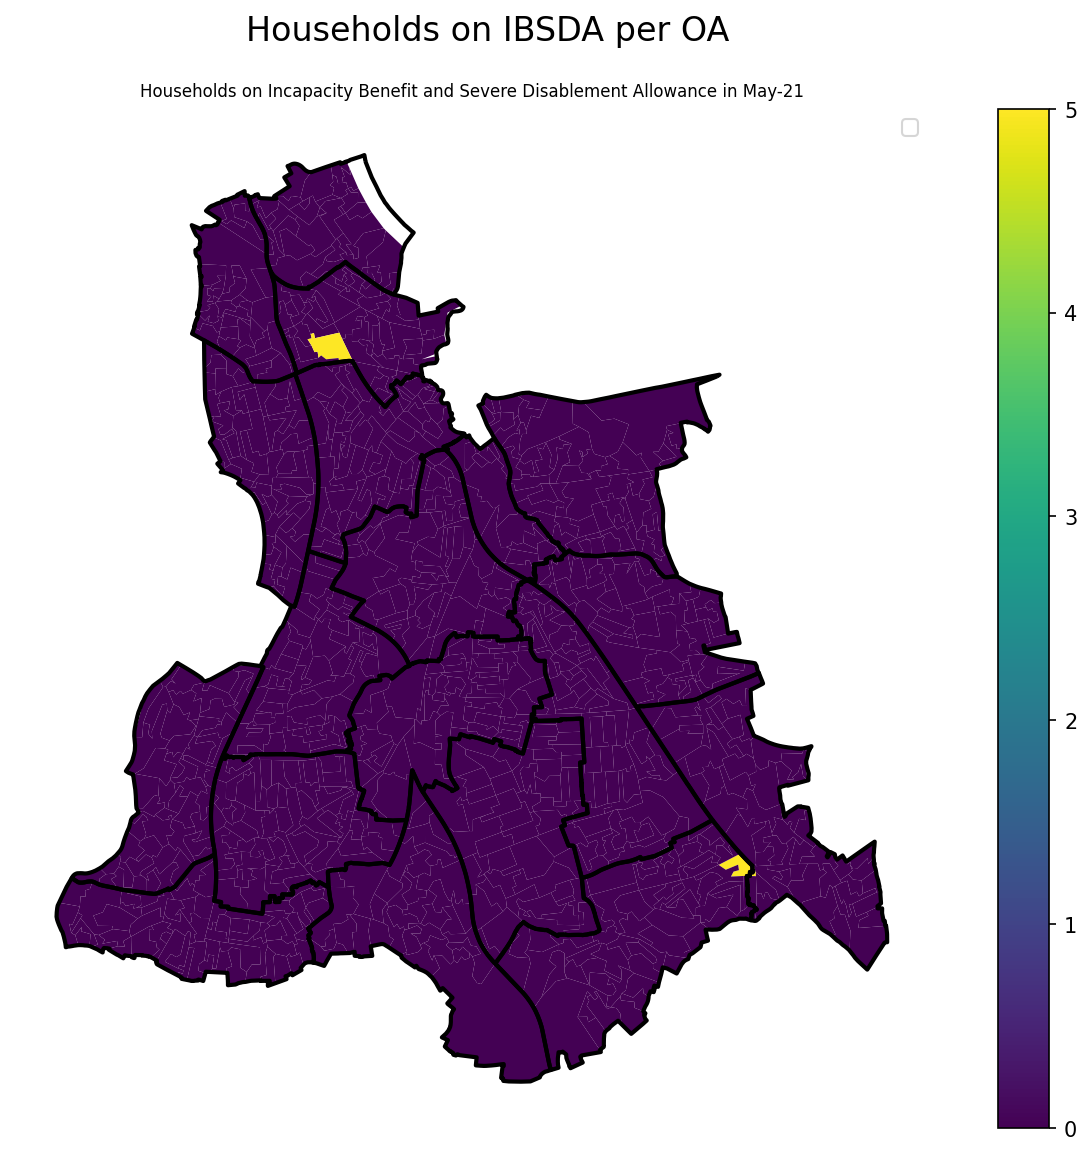

In [ ]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 9), dpi=150)
plt.suptitle('Households on IBSDA per OA', fontsize=16, y=.95)
plt.title('Households on Incapacity Benefit and Severe Disablement Allowance in '+epoch[0], fontsize=8)
education_oa_geom.plot(ax=ax, column="Incapacity Benefit and Severe Disablement Allowance", legend=True)
plt.legend()
wd22.plot(ax=ax, facecolor='none', linewidth=2, edgecolor='black')

plt.axis('off')

plt.savefig(f"{output_dir}/lbl_oa11_jsa.png", dpi=600)
plt.savefig(f"{output_dir}/lbl_oa11_jsa.pdf")